In [4]:
# All imports
import pandas as pd
import numpy as np
import ast
from scipy.sparse import hstack
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import Ridge
from sklearn.svm import LinearSVR
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch.utils.data import Dataset
from transformers import DistilBertForSequenceClassification, DistilBertTokenizerFast, Trainer, TrainingArguments, default_data_collator
from sklearn.metrics import mean_squared_error, accuracy_score

# Set style for publication-quality figures
plt.style.use('seaborn-v0_8-paper')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 12
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
plt.rcParams['legend.fontsize'] = 10
plt.rcParams['figure.titlesize'] = 16

# Load data
dataVer = "review-Vermont_10.json.gz"
dataMeta = "meta-Vermont.json.gz"

df_meta = pd.read_json(dataMeta, lines=True, compression="gzip")
df_ver = pd.read_json(dataVer, lines=True, compression="gzip")


In [5]:
# Merge review and metadata dataframes
df = df_ver.merge(df_meta, on="gmap_id", how="left")

# Remove rows with missing text
print("Before removing missing text:", len(df))
df = df.dropna(subset=["text"])
print("After removing missing text:", len(df))

# Remove duplicate reviews (same user reviewing same business)
print("Before removing duplicates:", len(df))
df = df.drop_duplicates(subset=['user_id', 'gmap_id'])
print("After removing duplicates:", len(df))

# Remove unnecessary columns
useless = ["name_x", "name_y", "time", "pics", "resp", "address",
           "relative_results", "state", "url", "latitude", "longitude", "MISC"]
maybe = ["description"] # num_of_reviews
df = df.drop(columns=useless + maybe)

# Remove rows with missing ratings
df = df.dropna(subset=['rating'])
print("After removing missing ratings:", len(df))

#number of reviews recalcualte
num_reviews = df.groupby('gmap_id')['rating'].count().rename('num_of_reviews')

#average rating recalculate
avg_rating = df.groupby('gmap_id')['rating'].mean().rename('avg_rating')

# combine back into dataframe
df = df.drop(columns=['num_of_reviews','avg_rating'], errors='ignore')
df = df.merge(num_reviews, on='gmap_id', how='left')
df = df.merge(avg_rating, on='gmap_id', how='left')

# Save preprocessed data
df.to_csv("merged.csv", index=False)
print("Preprocessed data saved to merged.csv")

Before removing missing text: 324981
After removing missing text: 178326
Before removing duplicates: 178326
After removing duplicates: 174998
After removing missing ratings: 174998
After removing missing ratings: 174998
Preprocessed data saved to merged.csv
Preprocessed data saved to merged.csv


In [6]:
# Display sample of preprocessed data
df.head()

,user_id,rating,text,gmap_id,category,price,hours,num_of_reviews,avg_rating
0,1.180269e+20,5,Always done right from wood stove to screens!,0x89e02445cb9db457:0x37f42bff4edf7a43,"[Security system supplier, Fire protection equ...",None,"[[Thursday, 8AM–5PM], [Friday, 8AM–5PM], [Satu...",8,5.0
1,1.015327e+20,5,A great company to work with. Their sales and...,0x89e02445cb9db457:0x37f42bff4edf7a43,"[Security system supplier, Fire protection equ...",None,"[[Thursday, 8AM–5PM], [Friday, 8AM–5PM], [Satu...",8,5.0
2,1.154041e+20,5,Great place to do business with staff was grea...,0x89e02445cb9db457:0x37f42bff4edf7a43,"[Security system supplier, Fire protection equ...",None,"[[Thursday, 8AM–5PM], [Friday, 8AM–5PM], [Satu...",8,5.0
3,1.047893e+20,5,"Awesome Customer service, quick response, and ...",0x89e02445cb9db457:0x37f42bff4edf7a43,"[Security system supplier, Fire protection equ...",None,"[[Thursday, 8AM–5PM], [Friday, 8AM–5PM], [Satu...",8,5.0
4,1.089807e+20,5,"If you need a top quality job, by a group of p...",0x89e02445cb9db457:0x37f42bff4edf7a43,"[Security system supplier, Fire protection equ...",None,"[[Thursday, 8AM–5PM], [Friday, 8AM–5PM], [Satu...",8,5.0


# II. Data Exploration and Visualization

This section provides visualizations and statistical analysis of the dataset to understand the data distribution and relationships between features.


In [7]:
# Load preprocessed data for visualization
df_viz = pd.read_csv("merged.csv")

# Basic statistics
print("Dataset Statistics:")
print(f"Total reviews: {len(df_viz):,}")
print(f"Unique users: {df_viz['user_id'].nunique():,}")
print(f"Unique businesses: {df_viz['gmap_id'].nunique():,}")
print(f"\nRating Statistics:")
print(df_viz['rating'].describe())

# Calculate text length
df_viz['text_length'] = df_viz['text'].astype(str).apply(len)
print(f"\nText Length Statistics:")
print(df_viz['text_length'].describe())


Dataset Statistics:
Total reviews: 174,998
Unique users: 12,655
Unique businesses: 5,040

Rating Statistics:
count    174998.000000
mean          4.329941
std           1.044621
min           1.000000
25%           4.000000
50%           5.000000
75%           5.000000
max           5.000000
Name: rating, dtype: float64

Text Length Statistics:
count    174998.000000
mean        112.752849
std         164.424598
min           1.000000
25%          31.000000
50%          61.000000
75%         130.000000
max        4092.000000
Name: text_length, dtype: float64


## A. Rating Distribution


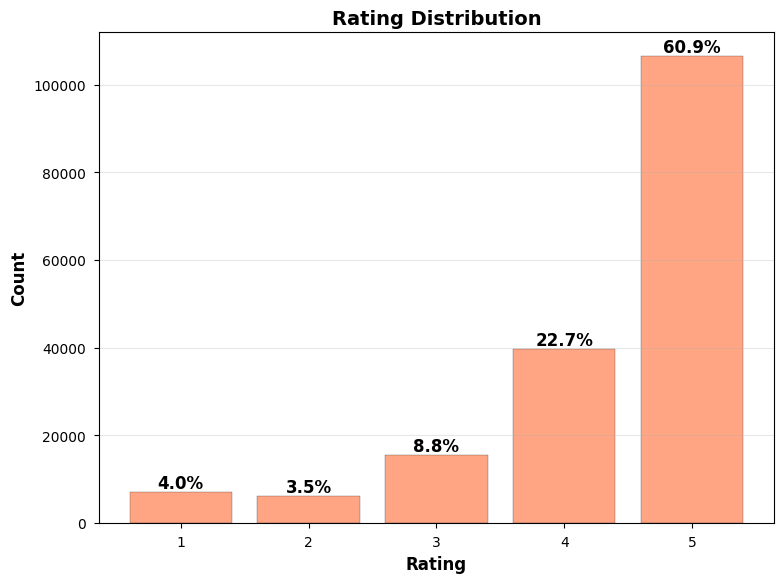


Rating Distribution:
  Rating 1: 7,044 (4.0%)
  Rating 2: 6,130 (3.5%)
  Rating 3: 15,483 (8.8%)
  Rating 4: 39,727 (22.7%)
  Rating 5: 106,614 (60.9%)


In [8]:
# Rating distribution
fig, ax = plt.subplots(1, 1, figsize=(8, 6))

# Bar plot with percentages
rating_counts = df_viz['rating'].value_counts().sort_index()
rating_pct = (rating_counts / len(df_viz) * 100).round(1)
bars = ax.bar(rating_counts.index, rating_counts.values, edgecolor='black', alpha=0.7, color='coral')
ax.set_xlabel('Rating', fontweight='bold')
ax.set_ylabel('Count', fontweight='bold')
ax.set_title('Rating Distribution', fontweight='bold')
ax.set_xticks([1, 2, 3, 4, 5])
ax.grid(axis='y', alpha=0.3)

# Add percentage labels on bars
for idx, val in zip(rating_counts.index, rating_counts.values):
    ax.text(idx, val, f'{rating_pct[idx]:.1f}%',
            ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.savefig('rating_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\nRating Distribution:")
for rating in sorted(rating_counts.index):
    print(f"  Rating {int(rating)}: {rating_counts[rating]:,} ({rating_pct[rating]:.1f}%)")


## B. Text Length Analysis


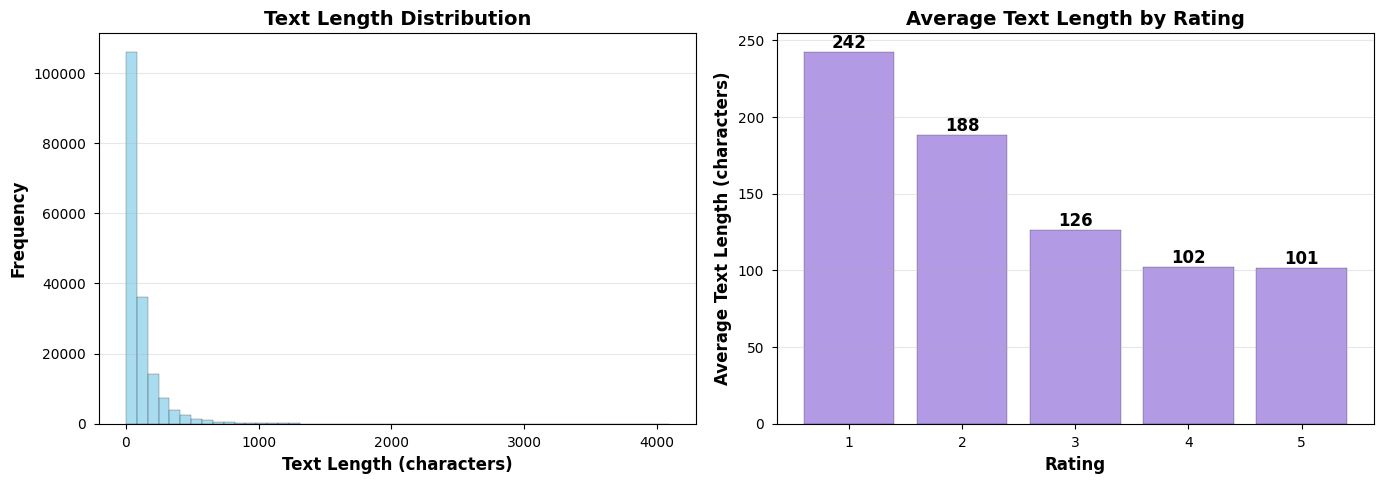


Average Text Length by Rating:
  Rating 1: 242.5 characters
  Rating 2: 188.3 characters
  Rating 3: 126.4 characters
  Rating 4: 102.5 characters
  Rating 5: 101.7 characters


In [9]:
# Text length distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram
axes[0].hist(df_viz['text_length'], bins=50, edgecolor='black', alpha=0.7, color='skyblue')
axes[0].set_xlabel('Text Length (characters)', fontweight='bold')
axes[0].set_ylabel('Frequency', fontweight='bold')
axes[0].set_title('Text Length Distribution', fontweight='bold')
axes[0].grid(axis='y', alpha=0.3)

# Rating vs Text Length
rating_text_length = df_viz.groupby('rating')['text_length'].mean()
bars = axes[1].bar(rating_text_length.index, rating_text_length.values,
                   edgecolor='black', alpha=0.7, color='mediumpurple')
axes[1].set_xlabel('Rating', fontweight='bold')
axes[1].set_ylabel('Average Text Length (characters)', fontweight='bold')
axes[1].set_title('Average Text Length by Rating', fontweight='bold')
axes[1].set_xticks([1, 2, 3, 4, 5])
axes[1].grid(axis='y', alpha=0.3)

# Add value labels on bars
for idx, val in zip(rating_text_length.index, rating_text_length.values):
    axes[1].text(idx, val, f'{int(val)}',
                ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.savefig('text_length_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\nAverage Text Length by Rating:")
for rating in sorted(rating_text_length.index):
    print(f"  Rating {int(rating)}: {rating_text_length[rating]:.1f} characters")


## C. Correlation Analysis


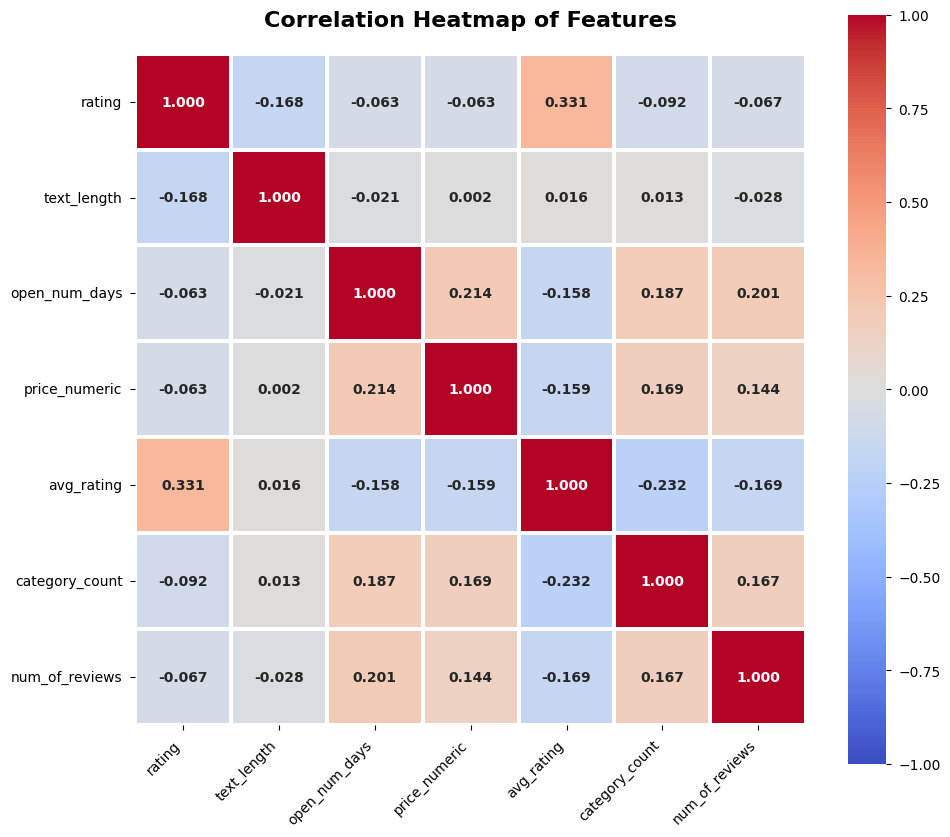


Correlation Matrix:
                rating  text_length  open_num_days  price_numeric  avg_rating  \
rating           1.000       -0.168         -0.063         -0.063       0.331   
text_length     -0.168        1.000         -0.021          0.002       0.016   
open_num_days   -0.063       -0.021          1.000          0.214      -0.158   
price_numeric   -0.063        0.002          0.214          1.000      -0.159   
avg_rating       0.331        0.016         -0.158         -0.159       1.000   
category_count  -0.092        0.013          0.187          0.169      -0.232   
num_of_reviews  -0.067       -0.028          0.201          0.144      -0.169   

                category_count  num_of_reviews  
rating                  -0.092          -0.067  
text_length              0.013          -0.028  
open_num_days            0.187           0.201  
price_numeric            0.169           0.144  
avg_rating              -0.232          -0.169  
category_count           1.000      

In [10]:
# ============================================================================
# Feature Engineering for Correlation Analysis
# ============================================================================
df_corr = df_viz.copy()

# --- Feature 1: Text Length ---
df_corr['text_length'] = df_corr['text'].astype(str).str.len()

# --- Feature 2: Number of open days per week ---
def count_open_days(hours_str):
    """Count the number of days a business is open per week.

    Args:
        hours_str: String like "[[Thursday, 8AM–5PM], [Friday, 8AM–5PM], ...]"
                   or already parsed list

    Returns:
        Number of days the business is open (0-7)
    """
    if pd.isna(hours_str):
        return 0

    # Parse hours string to list if it's a string
    try:
        if isinstance(hours_str, str):
            # Try to parse as Python literal (list of lists)
            hours_list = ast.literal_eval(hours_str)
        else:
            # Already a list
            hours_list = hours_str

        # Validate that we got a list
        if not isinstance(hours_list, list):
            return 0

        # Count days that are not 'Closed'
        # Format: [[DayName, Hours], [DayName, Hours], ...]
        # Example: [[Thursday, 8AM–5PM], [Friday, 8AM–5PM], ...]
        open_count = 0
        for day_info in hours_list:
            # day_info should be a list like [DayName, Hours]
            if isinstance(day_info, list) and len(day_info) >= 2:
                # Check if the hours part (index 1) is not 'Closed'
                hours_value = day_info[1]
                if hours_value != 'Closed' and hours_value is not None:
                    open_count += 1

        return open_count
    except (ValueError, SyntaxError, TypeError) as e:
        # If parsing fails, return 0
        return 0

df_corr['open_num_days'] = df_corr['hours'].apply(count_open_days)

# --- Feature 3: Price (converted to numerical) ---
if 'price' in df_corr.columns:
    # Convert price to numeric using string length
    df_corr['price_numeric'] = df_corr['price'].astype(str).str.len()
    # Handle None/nan cases (set to 0)
    df_corr.loc[df_corr['price'].isna() | (df_corr['price'].astype(str) == 'None'), 'price_numeric'] = 0
else:
    df_corr['price_numeric'] = 0

# --- Feature 4: Average Rating (excluding current review) ---
# Calculate avg_rating excluding current review to avoid data leakage
business_stats = df_corr.groupby('gmap_id')['rating'].agg(['sum', 'count']).reset_index()
business_stats.columns = ['gmap_id', 'total_rating', 'count']

df_corr = df_corr.merge(business_stats, on='gmap_id', how='left')
df_corr['avg_rating'] = (df_corr['total_rating'] - df_corr['rating']) / (df_corr['count'] - 1)
# Handle businesses with only one review
# Not needed in 10 core
# df_corr.loc[df_corr['count'] == 1, 'avg_rating'] = df_corr.loc[df_corr['count'] == 1, 'rating']
# df_corr = df_corr.drop(columns=['total_rating', 'count'])

# --- Feature 5: Category Count (number of categories per business) ---
def count_categories(cat_str):
    """Count the number of categories for a business."""
    if pd.isna(cat_str):
        return 0
    try:
        if isinstance(cat_str, str):
            cat_list = ast.literal_eval(cat_str)
        else:
            cat_list = cat_str
        return len(cat_list) if isinstance(cat_list, list) else 0
    except:
        return 0

if 'category' in df_corr.columns:
    df_corr['category_count'] = df_corr['category'].apply(count_categories)
else:
    df_corr['category_count'] = 0

# --- Feature 6: Number of Reviews ---
if 'num_of_reviews' in df_corr.columns:
    df_corr['num_of_reviews'] = pd.to_numeric(df_corr['num_of_reviews'], errors='raise')


# ============================================================================
# Correlation Analysis
# ============================================================================
# Select numerical features for correlation analysis
corr_features = ['rating', 'text_length', 'open_num_days', 'price_numeric',
                 'avg_rating', 'category_count', 'num_of_reviews']
df_corr_subset = df_corr[corr_features].dropna()

# Calculate correlation matrix
corr_matrix = df_corr_subset.corr()

# ============================================================================
# Visualization
# ============================================================================
n_features = len(corr_matrix)
fig_size = max(10, n_features * 1.2)

plt.figure(figsize=(fig_size, fig_size))
sns.heatmap(
    corr_matrix,
    annot=True,
    fmt='.3f',
    cmap='coolwarm',
    center=0,
    square=True,
    linewidths=1.5,
    cbar_kws={"shrink": 0.8},
    vmin=-1,
    vmax=1,
    annot_kws={
        'fontsize': max(10, int(14 - n_features * 0.5)),
        'fontweight': 'bold'
    },
    xticklabels=corr_matrix.columns,
    yticklabels=corr_matrix.columns
)
plt.title('Correlation Heatmap of Features', fontsize=16, fontweight='bold', pad=20)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig('correlation_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

# ============================================================================
# Results Summary
# ============================================================================
print(f"\n{'='*60}")
print("Correlation Matrix:")
print(f"{'='*60}")
print(corr_matrix.round(3))

# Key correlations with rating
print(f"\n{'='*60}")
print("Correlation with Rating (Target Variable):")
print(f"{'='*60}")
rating_corrs = corr_matrix['rating'].sort_values(ascending=False)
for feature, corr_value in rating_corrs.items():
    if feature != 'rating':
        print(f"  {feature:15s}: {corr_value:6.3f}")
print(f"{'='*60}")


# III. Modeling

This section describes the models we implement for rating prediction. We start with simple baselines and progressively build more sophisticated models that incorporate text features and metadata.


## A. Baseline Models

We implement three baseline models to establish a performance floor:

1. **Global Mean**: Predicts the average rating across all training examples
2. **User Means**: Predicts the user's average rating across all training examples.
3. **Item Means**: Predicts the item's average rating across all training examples.

In [11]:
# ============================================================================
# Data Loading and Preparation
# ============================================================================
df = pd.read_csv("merged.csv", usecols=['user_id', 'rating', 'gmap_id'])
df = df.dropna(subset=['user_id', 'rating', 'gmap_id'])
df['rating'] = df['rating'].astype(float)

# ============================================================================
# Train/Test Split (80/20)
# ============================================================================
train, test = train_test_split(
    df,
    test_size=0.2,
    random_state=42,
    stratify=df['rating']
)

print(f"\nData Split:")
print(f"  Train: {len(train):,} samples ({len(train)/len(df)*100:.1f}%)")
print(f"  Test:  {len(test):,} samples ({len(test)/len(df)*100:.1f}%)")

# ============================================================================
# Baseline 1: Global Mean
# ============================================================================
# Predict the average rating across all training examples
global_mean = train['rating'].mean()
preds_global = [global_mean] * len(test)
mse_global = mean_squared_error(test['rating'], preds_global)

print(f"\n{'='*60}")
print("Baseline 1: Global Mean")
print(f"{'='*60}")
print(f"Prediction: {global_mean:.4f} (constant)")
print(f"Test MSE:   {mse_global:.4f}")
print(f"{'='*60}")


# ============================================================================
# Baseline 2: User Means
# ============================================================================
# Predict the average rating the user gives across all training examples
# If the user isn't found in the training data, use the global average instead
user_means = train.groupby('user_id')['rating'].mean()
preds_user = test['user_id'].map(user_means)
preds_user = preds_user.fillna(global_mean)
mse_user = mean_squared_error(test['rating'], preds_user)

print(f"\n{'='*60}")
print("Baseline 2: User Means")
print(f"{'='*60}")
print(f"Test MSE:   {mse_user:.4f}")
print(f"{'='*60}")


# ============================================================================
# Baseline 3: Item Means
# ============================================================================
# Predict the average rating of the item
# If the item isn't found in the training data, use the global average instead
item_means = train.groupby('gmap_id')['rating'].mean()
preds_item = test['gmap_id'].map(item_means)
preds_item = preds_item.fillna(global_mean)

mse_item = mean_squared_error(test['rating'], preds_item)

print(f"\n{'='*60}")
print("Baseline 3: Item Means")
print(f"{'='*60}")
print(f"Test MSE:   {mse_item:.4f}")
print(f"{'='*60}")


Data Split:
  Train: 139,998 samples (80.0%)
  Test:  35,000 samples (20.0%)

Baseline 1: Global Mean
Prediction: 4.3299 (constant)
Test MSE:   1.0913

Baseline 2: User Means
Test MSE:   0.9750

Baseline 3: Item Means
Test MSE:   0.9822


## B. Text-based Linear Model (Main Model #1)

**Intuition**: The sentiment and expressions in text are most directly connected to ratings. Words, phrases, and sentiment expressions contained in review text provide key information for predicting the ratings assigned by users.

We use:
- **TF-IDF vectorization** to convert text into numerical features
- **Ridge Regression** for regularization and to handle the high-dimensional feature space


In [12]:
# ============================================================================
# Data Loading and Preparation
# ============================================================================
df = pd.read_csv("merged.csv", usecols=['text', 'rating'])
df = df.dropna(subset=['text', 'rating'])
df['text'] = df['text'].astype(str)
df['rating'] = df['rating'].astype(float)

# ============================================================================
# Train/Validation/Test Split (70/15/15)
# ============================================================================
# Step 1: Separate test set (15%)
X_temp, X_test, y_temp, y_test = train_test_split(
    df['text'], df['rating'],
    test_size=0.15,
    random_state=42,
    stratify=df['rating']
)

# Step 2: Split remaining 85% into train (70%) and validation (15%)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp,
    test_size=0.15/0.85,  # ~17.6% of 85% = 15% of total
    random_state=42,
    stratify=y_temp
)

print(f"\nData Split:")
print(f"  Train:      {len(X_train):,} samples ({len(X_train)/len(df)*100:.1f}%)")
print(f"  Validation: {len(X_val):,} samples ({len(X_val)/len(df)*100:.1f}%)")
print(f"  Test:       {len(X_test):,} samples ({len(X_test)/len(df)*100:.1f}%)")

# ============================================================================
# Feature Engineering: TF-IDF Vectorization
# ============================================================================
tfidf = TfidfVectorizer(
    max_features=50000,
    ngram_range=(1, 2),    # Unigrams and bigrams
    min_df=2,              # Ignore terms in < 2 documents
    max_df=0.95            # Ignore terms in > 95% of documents
)

X_train_tfidf = tfidf.fit_transform(X_train)
X_val_tfidf = tfidf.transform(X_val)
X_test_tfidf = tfidf.transform(X_test)

print(f"\nTF-IDF Features:")
print(f"  Shape: {X_train_tfidf.shape}")
print(f"  Vocabulary size: {len(tfidf.vocabulary_):,}")

# ============================================================================
# Hyperparameter Tuning on Validation Set
# ============================================================================
alpha_values = [0.1, 0.5, 1.0, 2.0, 5.0, 10.0]
best_alpha = 1.0
best_val_mse = float('inf')

print(f"\n{'='*60}")
print("Hyperparameter Tuning (Validation Set)")
print(f"{'='*60}")
for alpha in alpha_values:
    model_temp = Ridge(alpha=alpha)
    model_temp.fit(X_train_tfidf, y_train)
    y_pred_val = model_temp.predict(X_val_tfidf)
    val_mse = mean_squared_error(y_val, y_pred_val)
    print(f"  Alpha = {alpha:4.1f}:  Validation MSE = {val_mse:.4f}")
    if val_mse < best_val_mse:
        best_val_mse = val_mse
        best_alpha = alpha

print(f"\nBest hyperparameters:")
print(f"  Alpha = {best_alpha:.1f}")
print(f"  Validation MSE = {best_val_mse:.4f}")

# ============================================================================
# Final Model Training and Evaluation
# ============================================================================
# Train on full training set with best hyperparameters
model_text = Ridge(alpha=best_alpha)
model_text.fit(X_train_tfidf, y_train)

# Evaluate on test set (final evaluation only)
y_pred_text = model_text.predict(X_test_tfidf)
mse_text = mean_squared_error(y_test, y_pred_text)

print(f"\n{'='*60}")
print(f"Final Model Performance (Test Set)")
print(f"{'='*60}")
print(f"Model: Text-based (TF-IDF + Ridge)")
print(f"Alpha: {best_alpha:.1f}")
print(f"Test MSE: {mse_text:.4f}")
print(f"{'='*60}")



Data Split:
  Train:      122,498 samples (70.0%)
  Validation: 26,250 samples (15.0%)
  Test:       26,250 samples (15.0%)

TF-IDF Features:
  Shape: (122498, 50000)
  Vocabulary size: 50,000

Hyperparameter Tuning (Validation Set)

TF-IDF Features:
  Shape: (122498, 50000)
  Vocabulary size: 50,000

Hyperparameter Tuning (Validation Set)
  Alpha =  0.1:  Validation MSE = 0.6034
  Alpha =  0.1:  Validation MSE = 0.6034
  Alpha =  0.5:  Validation MSE = 0.5091
  Alpha =  0.5:  Validation MSE = 0.5091
  Alpha =  1.0:  Validation MSE = 0.4902
  Alpha =  1.0:  Validation MSE = 0.4902
  Alpha =  2.0:  Validation MSE = 0.4851
  Alpha =  2.0:  Validation MSE = 0.4851
  Alpha =  5.0:  Validation MSE = 0.4989
  Alpha =  5.0:  Validation MSE = 0.4989
  Alpha = 10.0:  Validation MSE = 0.5244

Best hyperparameters:
  Alpha = 2.0
  Validation MSE = 0.4851
  Alpha = 10.0:  Validation MSE = 0.5244

Best hyperparameters:
  Alpha = 2.0
  Validation MSE = 0.4851

Final Model Performance (Test Set)
Mod

## C. Text + Metadata Model

This model combines text features with metadata to capture both semantic content and contextual information about the business.

**Features**:
- **TF-IDF(text)**: Text vectorization
- **avg_rating**: Average rating of the business (excluding current review) - high correlation feature
- **text_length**: Length of review text - correlation feature

We use **Ridge Regression** for this model.


In [13]:
# ============================================================================
# Data Loading and Preparation
# ============================================================================
df = pd.read_csv("merged.csv", usecols=['text', 'rating', 'gmap_id'])
df = df.dropna(subset=['text', 'rating', 'gmap_id'])
df['text'] = df['text'].astype(str)
df['rating'] = df['rating'].astype(float)

# ============================================================================
# Train/Validation/Test Split (70/15/15)
# ============================================================================
# Step 1: Separate test set (15%)
df_temp, df_test = train_test_split(
    df,
    test_size=0.15,
    random_state=42,
    stratify=df['rating']
)

# Step 2: Split remaining 85% into train (70%) and validation (15%)
df_train, df_val = train_test_split(
    df_temp,
    test_size=0.15/0.85,  # ~17.6% of 85% = 15% of total
    random_state=42,
    stratify=df_temp['rating']
)

print(f"\nData Split:")
print(f"  Train:      {len(df_train):,} samples ({len(df_train)/len(df)*100:.1f}%)")
print(f"  Validation: {len(df_val):,} samples ({len(df_val)/len(df)*100:.1f}%)")
print(f"  Test:       {len(df_test):,} samples ({len(df_test)/len(df)*100:.1f}%)")

# ============================================================================
# Feature Engineering
# ============================================================================

# --- Feature 1: TF-IDF Vectorization ---
tfidf = TfidfVectorizer(
    max_features=50000,
    ngram_range=(1, 2),
    min_df=2,
    max_df=0.95
)

X_train_tfidf = tfidf.fit_transform(df_train['text'])
X_val_tfidf = tfidf.transform(df_val['text'])
X_test_tfidf = tfidf.transform(df_test['text'])

print(f"\nTF-IDF Features:")
print(f"  Shape: {X_train_tfidf.shape}")

# --- Feature 2: Average Rating (excluding current review) ---
# Calculate business statistics from train set only (avoid data leakage)
business_stats = df_train.groupby('gmap_id')['rating'].agg(['sum', 'count']).reset_index()
business_stats.columns = ['gmap_id', 'total_rating', 'count']

# Train set: exclude current review
df_train_merged = df_train.merge(business_stats, on='gmap_id', how='left')
df_train_merged['avg_rating'] = (df_train_merged['total_rating'] - df_train_merged['rating']) / (df_train_merged['count'] - 1)
df_train_merged.loc[df_train_merged['count'] == 1, 'avg_rating'] = df_train_merged.loc[df_train_merged['count'] == 1, 'rating']
avg_rating_train = df_train_merged['avg_rating'].fillna(df_train['rating'].mean()).values

# Validation/Test sets: use train statistics only
df_val_merged = df_val.merge(business_stats, on='gmap_id', how='left')
df_val_merged['avg_rating'] = df_val_merged['total_rating'] / df_val_merged['count']
avg_rating_val = df_val_merged['avg_rating'].fillna(df_train['rating'].mean()).values

df_test_merged = df_test.merge(business_stats, on='gmap_id', how='left')
df_test_merged['avg_rating'] = df_test_merged['total_rating'] / df_test_merged['count']
avg_rating_test = df_test_merged['avg_rating'].fillna(df_train['rating'].mean()).values

# --- Feature 3: Text Length ---
text_length_train = df_train['text'].str.len().values
text_length_val = df_val['text'].str.len().values
text_length_test = df_test['text'].str.len().values

print(f"\nMetadata Features:")
print(f"  Avg Rating - Train: {np.mean(avg_rating_train):.2f}, Val: {np.mean(avg_rating_val):.2f}, Test: {np.mean(avg_rating_test):.2f}")
print(f"  Text Length - Train: {np.mean(text_length_train):.1f}, Val: {np.mean(text_length_val):.1f}, Test: {np.mean(text_length_test):.1f}")

# --- Combine and Scale Features ---
metadata_train = np.column_stack([avg_rating_train, text_length_train])
metadata_val = np.column_stack([avg_rating_val, text_length_val])
metadata_test = np.column_stack([avg_rating_test, text_length_test])

# Scale metadata features (fit only on train to avoid data leakage)
scaler = StandardScaler()
metadata_train_scaled = scaler.fit_transform(metadata_train)
metadata_val_scaled = scaler.transform(metadata_val)
metadata_test_scaled = scaler.transform(metadata_test)

# Combine TF-IDF (sparse) + metadata (dense)
X_train_combined = hstack([X_train_tfidf, metadata_train_scaled])
X_val_combined = hstack([X_val_tfidf, metadata_val_scaled])
X_test_combined = hstack([X_test_tfidf, metadata_test_scaled])

print(f"\nCombined Features:")
print(f"  Train: {X_train_combined.shape}")
print(f"  Val:   {X_val_combined.shape}")
print(f"  Test:  {X_test_combined.shape}")

# ============================================================================
# Hyperparameter Tuning on Validation Set
# ============================================================================
alpha_values = [0.1, 0.5, 1.0, 2.0, 5.0, 10.0]
best_alpha = 1.0
best_val_mse = float('inf')

print(f"\n{'='*60}")
print("Hyperparameter Tuning (Validation Set)")
print(f"{'='*60}")
for alpha in alpha_values:
    model_temp = Ridge(alpha=alpha)
    model_temp.fit(X_train_combined, df_train['rating'])
    y_pred_val = model_temp.predict(X_val_combined)
    val_mse = mean_squared_error(df_val['rating'], y_pred_val)
    print(f"  Alpha = {alpha:4.1f}:  Validation MSE = {val_mse:.4f}")
    if val_mse < best_val_mse:
        best_val_mse = val_mse
        best_alpha = alpha

print(f"\nBest hyperparameters:")
print(f"  Alpha = {best_alpha:.1f}")
print(f"  Validation MSE = {best_val_mse:.4f}")

# ============================================================================
# Final Model Training and Evaluation
# ============================================================================
# Train on full training set with best hyperparameters
model_ridge = Ridge(alpha=best_alpha)
model_ridge.fit(X_train_combined, df_train['rating'])

# Evaluate on test set (final evaluation only)
y_pred_ridge = model_ridge.predict(X_test_combined)
mse_ridge = mean_squared_error(df_test['rating'], y_pred_ridge)

print(f"\n{'='*60}")
print(f"Final Model Performance (Test Set)")
print(f"{'='*60}")
print(f"Model: Text + Metadata (TF-IDF + avg_rating + text_length + Ridge)")
print(f"Alpha: {best_alpha:.1f}")
print(f"Test MSE: {mse_ridge:.4f}")
print(f"{'='*60}")



Data Split:
  Train:      122,498 samples (70.0%)
  Validation: 26,250 samples (15.0%)
  Test:       26,250 samples (15.0%)

TF-IDF Features:
  Shape: (122498, 50000)

Metadata Features:
  Avg Rating - Train: 4.33, Val: 4.33, Test: 4.33
  Text Length - Train: 112.7, Val: 112.6, Test: 112.9

Combined Features:
  Train: (122498, 50002)
  Val:   (26250, 50002)
  Test:  (26250, 50002)

Hyperparameter Tuning (Validation Set)

TF-IDF Features:
  Shape: (122498, 50000)

Metadata Features:
  Avg Rating - Train: 4.33, Val: 4.33, Test: 4.33
  Text Length - Train: 112.7, Val: 112.6, Test: 112.9

Combined Features:
  Train: (122498, 50002)
  Val:   (26250, 50002)
  Test:  (26250, 50002)

Hyperparameter Tuning (Validation Set)
  Alpha =  0.1:  Validation MSE = 0.5950
  Alpha =  0.1:  Validation MSE = 0.5950
  Alpha =  0.5:  Validation MSE = 0.5018
  Alpha =  0.5:  Validation MSE = 0.5018
  Alpha =  1.0:  Validation MSE = 0.4828
  Alpha =  1.0:  Validation MSE = 0.4828
  Alpha =  2.0:  Validation M

## D. LinearSVR Model

**Explanation**: Linear Support Vector Regression (LinearSVR) is a linear model that uses support vector machines for regression tasks. It can handle high-dimensional sparse data well and often performs better than Ridge regression for certain types of text classification problems.

We use **LinearSVR** with TF-IDF features for rating prediction.


In [14]:
# ============================================================================
# Data Loading and Preparation
# ============================================================================
df = pd.read_csv("merged.csv", usecols=['text', 'rating'])
df = df.dropna(subset=['text', 'rating'])
df['text'] = df['text'].astype(str)
df['rating'] = df['rating'].astype(float)

# ============================================================================
# Train/Validation/Test Split (70/15/15)
# ============================================================================
# Step 1: Separate test set (15%)
X_temp, X_test, y_temp, y_test = train_test_split(
    df['text'], df['rating'],
    test_size=0.15,
    random_state=42,
    stratify=df['rating']
)

# Step 2: Split remaining 85% into train (70%) and validation (15%)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp,
    test_size=0.15/0.85,
    random_state=42,
    stratify=y_temp
)

print(f"\nData Split:")
print(f"  Train:      {len(X_train):,} samples ({len(X_train)/len(df)*100:.1f}%)")
print(f"  Validation: {len(X_val):,} samples ({len(X_val)/len(df)*100:.1f}%)")
print(f"  Test:       {len(X_test):,} samples ({len(X_test)/len(df)*100:.1f}%)")

# ============================================================================
# Feature Engineering: TF-IDF Vectorization
# ============================================================================
tfidf = TfidfVectorizer(
    max_features=50000,
    ngram_range=(1, 2),    # Unigrams and bigrams
    min_df=2,              # Ignore terms in < 2 documents
    max_df=0.95            # Ignore terms in > 95% of documents
)

X_train_tfidf = tfidf.fit_transform(X_train)
X_val_tfidf = tfidf.transform(X_val)
X_test_tfidf = tfidf.transform(X_test)

print(f"\nTF-IDF Features:")
print(f"  Shape: {X_train_tfidf.shape}")
print(f"  Vocabulary size: {len(tfidf.vocabulary_):,}")

# ============================================================================
# Hyperparameter Tuning on Validation Set
# ============================================================================
# C: Regularization parameter (inverse of regularization strength)
# epsilon: Epsilon-tube (no penalty within this range)
C_values = [0.1, 0.5, 1.0, 2.0]
epsilon_values = [0.0, 0.1, 0.2]
best_C = 1.0
best_epsilon = 0.0
best_val_mse = float('inf')

print(f"\n{'='*60}")
print("Hyperparameter Tuning (Validation Set)")
print(f"{'='*60}")
for C in C_values:
    for epsilon in epsilon_values:
        model_temp = LinearSVR(C=C, epsilon=epsilon, max_iter=1000, random_state=42)
        model_temp.fit(X_train_tfidf, y_train)
        y_pred_val = model_temp.predict(X_val_tfidf)
        y_pred_val = np.clip(y_pred_val, 1.0, 5.0)  # Clip to valid rating range
        val_mse = mean_squared_error(y_val, y_pred_val)
        print(f"  C = {C:4.1f}, epsilon = {epsilon:.1f}:  Validation MSE = {val_mse:.4f}")
        if val_mse < best_val_mse:
            best_val_mse = val_mse
            best_C = C
            best_epsilon = epsilon

print(f"\nBest hyperparameters:")
print(f"  C = {best_C:.1f}")
print(f"  epsilon = {best_epsilon:.1f}")
print(f"  Validation MSE = {best_val_mse:.4f}")

# ============================================================================
# Final Model Training and Evaluation
# ============================================================================
# Train on full training set with best hyperparameters
model_svr = LinearSVR(C=best_C, epsilon=best_epsilon, max_iter=1000, random_state=42)
model_svr.fit(X_train_tfidf, y_train)

# Evaluate on test set (final evaluation only)
y_pred_svr = model_svr.predict(X_test_tfidf)
y_pred_svr = np.clip(y_pred_svr, 1.0, 5.0)  # Clip to valid rating range
mse_svr = mean_squared_error(y_test, y_pred_svr)

print(f"\n{'='*60}")
print(f"Final Model Performance (Test Set)")
print(f"{'='*60}")
print(f"Model: LinearSVR (TF-IDF + LinearSVR)")
print(f"C: {best_C:.1f}, epsilon: {best_epsilon:.1f}")
print(f"Test MSE: {mse_svr:.4f}")
print(f"{'='*60}")



Data Split:
  Train:      122,498 samples (70.0%)
  Validation: 26,250 samples (15.0%)
  Test:       26,250 samples (15.0%)

TF-IDF Features:
  Shape: (122498, 50000)
  Vocabulary size: 50,000

Hyperparameter Tuning (Validation Set)

TF-IDF Features:
  Shape: (122498, 50000)
  Vocabulary size: 50,000

Hyperparameter Tuning (Validation Set)
  C =  0.1, epsilon = 0.0:  Validation MSE = 0.6194
  C =  0.1, epsilon = 0.0:  Validation MSE = 0.6194
  C =  0.1, epsilon = 0.1:  Validation MSE = 0.5886
  C =  0.1, epsilon = 0.1:  Validation MSE = 0.5886
  C =  0.1, epsilon = 0.2:  Validation MSE = 0.5662
  C =  0.1, epsilon = 0.2:  Validation MSE = 0.5662
  C =  0.5, epsilon = 0.0:  Validation MSE = 0.5237
  C =  0.5, epsilon = 0.0:  Validation MSE = 0.5237
  C =  0.5, epsilon = 0.1:  Validation MSE = 0.5071
  C =  0.5, epsilon = 0.1:  Validation MSE = 0.5071
  C =  0.5, epsilon = 0.2:  Validation MSE = 0.4942
  C =  0.5, epsilon = 0.2:  Validation MSE = 0.4942
  C =  1.0, epsilon = 0.0:  Valid

## E. LinearSVR Model + METADATA

**Explanation**: This model extends the LinearSVR model by incorporating metadata features (avg_rating and text_length) along with TF-IDF features, similar to the Ridge Regression approach.

We use **LinearSVR** with TF-IDF features combined with metadata features (avg_rating and text_length) for rating prediction.

In [15]:
# ============================================================================
# Data Loading and Preparation
# ============================================================================
df = pd.read_csv("merged.csv", usecols=['text', 'rating', 'gmap_id'])
df = df.dropna(subset=['text', 'rating', 'gmap_id'])
df['text'] = df['text'].astype(str)
df['rating'] = df['rating'].astype(float)

# ============================================================================
# Train/Validation/Test Split (70/15/15)
# ============================================================================
# Step 1: Separate test set (15%)
df_temp, df_test = train_test_split(
    df,
    test_size=0.15,
    random_state=42,
    stratify=df['rating']
)

# Step 2: Split remaining 85% into train (70%) and validation (15%)
df_train, df_val = train_test_split(
    df_temp,
    test_size=0.15/0.85,  # ~17.6% of 85% = 15% of total
    random_state=42,
    stratify=df_temp['rating']
)

print(f"\nData Split:")
print(f"  Train:      {len(df_train):,} samples ({len(df_train)/len(df)*100:.1f}%)")
print(f"  Validation: {len(df_val):,} samples ({len(df_val)/len(df)*100:.1f}%)")
print(f"  Test:       {len(df_test):,} samples ({len(df_test)/len(df)*100:.1f}%)")

# ============================================================================
# Feature Engineering
# ============================================================================

# --- Feature 1: TF-IDF Vectorization ---
tfidf = TfidfVectorizer(
    max_features=50000,
    ngram_range=(1, 2),
    min_df=2,
    max_df=0.95
)

X_train_tfidf = tfidf.fit_transform(df_train['text'])
X_val_tfidf = tfidf.transform(df_val['text'])
X_test_tfidf = tfidf.transform(df_test['text'])

print(f"\nTF-IDF Features:")
print(f"  Shape: {X_train_tfidf.shape}")

# --- Feature 2: Average Rating (excluding current review) ---
# Calculate business statistics from train set only (avoid data leakage)
business_stats = df_train.groupby('gmap_id')['rating'].agg(['sum', 'count']).reset_index()
business_stats.columns = ['gmap_id', 'total_rating', 'count']

# Train set: exclude current review
df_train_merged = df_train.merge(business_stats, on='gmap_id', how='left')
df_train_merged['avg_rating'] = (df_train_merged['total_rating'] - df_train_merged['rating']) / (df_train_merged['count'] - 1)
df_train_merged.loc[df_train_merged['count'] == 1, 'avg_rating'] = df_train_merged.loc[df_train_merged['count'] == 1, 'rating']
avg_rating_train = df_train_merged['avg_rating'].fillna(df_train['rating'].mean()).values

# Validation/Test sets: use train statistics only
df_val_merged = df_val.merge(business_stats, on='gmap_id', how='left')
df_val_merged['avg_rating'] = df_val_merged['total_rating'] / df_val_merged['count']
avg_rating_val = df_val_merged['avg_rating'].fillna(df_train['rating'].mean()).values

df_test_merged = df_test.merge(business_stats, on='gmap_id', how='left')
df_test_merged['avg_rating'] = df_test_merged['total_rating'] / df_test_merged['count']
avg_rating_test = df_test_merged['avg_rating'].fillna(df_train['rating'].mean()).values

# --- Feature 3: Text Length ---
text_length_train = df_train['text'].str.len().values
text_length_val = df_val['text'].str.len().values
text_length_test = df_test['text'].str.len().values

print(f"\nMetadata Features:")
print(f"  Avg Rating - Train: {np.mean(avg_rating_train):.2f}, Val: {np.mean(avg_rating_val):.2f}, Test: {np.mean(avg_rating_test):.2f}")
print(f"  Text Length - Train: {np.mean(text_length_train):.1f}, Val: {np.mean(text_length_val):.1f}, Test: {np.mean(text_length_test):.1f}")

# --- Combine and Scale Features ---
metadata_train = np.column_stack([avg_rating_train, text_length_train])
metadata_val = np.column_stack([avg_rating_val, text_length_val])
metadata_test = np.column_stack([avg_rating_test, text_length_test])

# Scale metadata features (fit only on train to avoid data leakage)
scaler = StandardScaler()
metadata_train_scaled = scaler.fit_transform(metadata_train)
metadata_val_scaled = scaler.transform(metadata_val)
metadata_test_scaled = scaler.transform(metadata_test)

# Combine TF-IDF (sparse) + metadata (dense)
X_train_combined = hstack([X_train_tfidf, metadata_train_scaled])
X_val_combined = hstack([X_val_tfidf, metadata_val_scaled])
X_test_combined = hstack([X_test_tfidf, metadata_test_scaled])

print(f"\nCombined Features:")
print(f"  Train: {X_train_combined.shape}")
print(f"  Val:   {X_val_combined.shape}")
print(f"  Test:  {X_test_combined.shape}")

# ============================================================================
# Hyperparameter Tuning on Validation Set
# ============================================================================
# C: Regularization parameter (inverse of regularization strength)
# epsilon: Epsilon-tube (no penalty within this range)
C_values = [0.1, 0.5, 1.0, 2.0]
epsilon_values = [0.0, 0.1, 0.2]
best_C = 1.0
best_epsilon = 0.0
best_val_mse = float('inf')

print(f"\n{'='*60}")
print("Hyperparameter Tuning (Validation Set)")
print(f"{'='*60}")
for C in C_values:
    for epsilon in epsilon_values:
        model_temp = LinearSVR(C=C, epsilon=epsilon, max_iter=1000, random_state=42)
        model_temp.fit(X_train_combined, df_train['rating'])
        y_pred_val = model_temp.predict(X_val_combined)
        y_pred_val = np.clip(y_pred_val, 1.0, 5.0)  # Clip to valid rating range
        val_mse = mean_squared_error(df_val['rating'], y_pred_val)
        print(f"  C = {C:4.1f}, epsilon = {epsilon:.1f}:  Validation MSE = {val_mse:.4f}")
        if val_mse < best_val_mse:
            best_val_mse = val_mse
            best_C = C
            best_epsilon = epsilon

print(f"\nBest hyperparameters:")
print(f"  C = {best_C:.1f}")
print(f"  epsilon = {best_epsilon:.1f}")
print(f"  Validation MSE = {best_val_mse:.4f}")

# ============================================================================
# Final Model Training and Evaluation
# ============================================================================
# Train on full training set with best hyperparameters
model_svr_metadata = LinearSVR(C=best_C, epsilon=best_epsilon, max_iter=1000, random_state=42)
model_svr_metadata.fit(X_train_combined, df_train['rating'])

# Evaluate on test set (final evaluation only)
y_pred_svr_metadata = model_svr_metadata.predict(X_test_combined)
y_pred_svr_metadata = np.clip(y_pred_svr_metadata, 1.0, 5.0)  # Clip to valid rating range
mse_svr_metadata = mean_squared_error(df_test['rating'], y_pred_svr_metadata)

print(f"\n{'='*60}")
print(f"Final Model Performance (Test Set)")
print(f"{'='*60}")
print(f"Model: Text + Metadata (TF-IDF + avg_rating + text_length + LinearSVR)")
print(f"C: {best_C:.1f}, epsilon: {best_epsilon:.1f}")
print(f"Test MSE: {mse_svr_metadata:.4f}")
print(f"{'='*60}")


Data Split:
  Train:      122,498 samples (70.0%)
  Validation: 26,250 samples (15.0%)
  Test:       26,250 samples (15.0%)

TF-IDF Features:
  Shape: (122498, 50000)

Metadata Features:
  Avg Rating - Train: 4.33, Val: 4.33, Test: 4.33
  Text Length - Train: 112.7, Val: 112.6, Test: 112.9

Combined Features:
  Train: (122498, 50002)
  Val:   (26250, 50002)
  Test:  (26250, 50002)

Hyperparameter Tuning (Validation Set)

TF-IDF Features:
  Shape: (122498, 50000)

Metadata Features:
  Avg Rating - Train: 4.33, Val: 4.33, Test: 4.33
  Text Length - Train: 112.7, Val: 112.6, Test: 112.9

Combined Features:
  Train: (122498, 50002)
  Val:   (26250, 50002)
  Test:  (26250, 50002)

Hyperparameter Tuning (Validation Set)
  C =  0.1, epsilon = 0.0:  Validation MSE = 0.5926
  C =  0.1, epsilon = 0.0:  Validation MSE = 0.5926
  C =  0.1, epsilon = 0.1:  Validation MSE = 0.5648
  C =  0.1, epsilon = 0.1:  Validation MSE = 0.5648
  C =  0.1, epsilon = 0.2:  Validation MSE = 0.5459
  C =  0.1, eps

C:\Users\kgh31\AppData\Roaming\Python\Python313\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


  C =  1.0, epsilon = 0.0:  Validation MSE = 0.5096
  C =  1.0, epsilon = 0.1:  Validation MSE = 0.4955
  C =  1.0, epsilon = 0.1:  Validation MSE = 0.4955
  C =  1.0, epsilon = 0.2:  Validation MSE = 0.4847
  C =  1.0, epsilon = 0.2:  Validation MSE = 0.4847


C:\Users\kgh31\AppData\Roaming\Python\Python313\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


  C =  2.0, epsilon = 0.0:  Validation MSE = 0.5241


C:\Users\kgh31\AppData\Roaming\Python\Python313\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


  C =  2.0, epsilon = 0.1:  Validation MSE = 0.5101


C:\Users\kgh31\AppData\Roaming\Python\Python313\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


  C =  2.0, epsilon = 0.2:  Validation MSE = 0.5002

Best hyperparameters:
  C = 1.0
  epsilon = 0.2
  Validation MSE = 0.4847

Final Model Performance (Test Set)
Model: Text + Metadata (TF-IDF + avg_rating + text_length + LinearSVR)
C: 1.0, epsilon: 0.2
Test MSE: 0.4949

Final Model Performance (Test Set)
Model: Text + Metadata (TF-IDF + avg_rating + text_length + LinearSVR)
C: 1.0, epsilon: 0.2
Test MSE: 0.4949


## F. BERT Model

In [16]:
# ============================================================================
# Data Loading and Preparation
# ============================================================================
df = pd.read_csv("merged.csv", usecols=['text', 'rating', 'gmap_id'])
df = df.dropna(subset=['text', 'rating', 'gmap_id'])
df['text'] = df['text'].astype(str)
df['rating'] = df['rating'].astype(float)

# ============================================================================
# Train/Validation/Test Split (70/15/15)
# ============================================================================
# Step 1: Separate test set (15%)
df_temp, df_test = train_test_split(
    df, 
    test_size=0.15, 
    random_state=42, 
    stratify=df['rating']
)

# Step 2: Split remaining 85% into train (70%) and validation (15%)
df_train, df_val = train_test_split(
    df_temp, 
    test_size=0.15/0.85,  # ~17.6% of 85% = 15% of total
    random_state=42, 
    stratify=df_temp['rating']
)

print(f"\nData Split:")
print(f"  Train:      {len(df_train):,} samples ({len(df_train)/len(df)*100:.1f}%)")
print(f"  Validation: {len(df_val):,} samples ({len(df_val)/len(df)*100:.1f}%)")
print(f"  Test:       {len(df_test):,} samples ({len(df_test)/len(df)*100:.1f}%)")

# ============================================================================
# Tokenization and Dataset Preparation
# ============================================================================
import torch
from torch.utils.data import Dataset
from transformers import DistilBertForSequenceClassification, DistilBertTokenizerFast, Trainer, TrainingArguments, default_data_collator
import numpy as np
from sklearn.metrics import mean_squared_error, accuracy_score

#tokenizer
tokenizer = DistilBertTokenizerFast.from_pretrained("distilbert-base-uncased")

#encode
train_encodings = tokenizer(df_train['text'].tolist(), truncation=True, padding=True, max_length=128)
val_encodings = tokenizer(df_val['text'].tolist(), truncation=True, padding=True, max_length=128)
test_encodings = tokenizer(df_test['text'].tolist(), truncation=True, padding=True, max_length=128)

#develop data set
class RatingDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        # convert ratings 1–5 to 0–4
        self.labels = [l - 1 for l in labels]

    def __getitem__(self, idx):
        item = {k: torch.tensor(v[idx]) for k, v in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx], dtype=torch.long)
        return item
    
    def __len__(self):
        return len(self.labels)

train_dataset = RatingDataset(train_encodings, df_train['rating'].tolist())
val_dataset = RatingDataset(val_encodings, df_val['rating'].tolist())
test_dataset = RatingDataset(test_encodings, df_test['rating'].tolist())

# ============================================================================
# Model Initialization
# ============================================================================

num_labels = 5  # ratings 1–5
model = DistilBertForSequenceClassification.from_pretrained(
    "distilbert-base-uncased",
    num_labels=num_labels
)

# ============================================================================
# Training Arguments
# ============================================================================

training_args = TrainingArguments(
    output_dir="./bert_output",
    per_device_train_batch_size=64,
    per_device_eval_batch_size=64,
    num_train_epochs=3,
    learning_rate=3e-5,   
    weight_decay=0.01,
    fp16=True
)

# the loss is cross entropy
# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    data_collator=default_data_collator,
)
trainer.train()

# ============================================================================
# Final Model Evaluation
# ============================================================================

# save model so I don't have to train again
model.save_pretrained("./bert_rating_model")
tokenizer.save_pretrained("./bert_rating_model")
print("Model saved!")


Data Split:
  Train:      122,498 samples (70.0%)
  Validation: 26,250 samples (15.0%)
  Test:       26,250 samples (15.0%)


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
500,0.795100
1000,0.724100
1500,0.709700
2000,0.686200
2500,0.645200
3000,0.642500
3500,0.646300
4000,0.629500
4500,0.585400
5000,0.589500


Model saved!


In [17]:
# ============================================================================
# Final Model Evaluation/Part not repeat computation
# ============================================================================

model_path = "./bert_rating_model"

tokenizer = DistilBertTokenizerFast.from_pretrained(model_path)
model = DistilBertForSequenceClassification.from_pretrained(model_path)
model.eval()  # important for inference

trainer = Trainer(model=model, data_collator=default_data_collator)

# Make predictions
predictions = trainer.predict(test_dataset)

# logits -> class indices
preds = np.argmax(predictions.predictions, axis=-1)
# convert back to rating scale (1–5)
y_pred = preds + 1  
y_true = df_test['rating'].tolist()

# Evaluate on test set (final evaluation only)
mse_bert = mean_squared_error(y_true, y_pred)
rmse_bert = np.sqrt(mse_bert)
accuracy_bert = accuracy_score(y_true, y_pred)

print(f"\n{'='*60}")
print(f"Final Model Performance (Test Set)")
print(f"{'='*60}")
print(f"Model: DistilBERT (Text → Rating)")
print(f"Test MSE: {mse_bert:.4f}")
print(f"Test RMSE: {rmse_bert:.4f}")
print(f"Test Accuracy: {accuracy_bert:.4f}")
print(f"{'='*60}")


Final Model Performance (Test Set)
Model: DistilBERT (Text → Rating)
Test MSE: 0.4632
Test RMSE: 0.6806
Test Accuracy: 0.7107


## IV. Evaluation

### A. Evaluation Context: Metrics and Justification

**Primary Metric: Mean Squared Error (MSE)**

For this rating prediction task, we use **Mean Squared Error (MSE)** as our primary evaluation metric.

$$\text{MSE} = \frac{1}{n}\sum_{i=1}^{n}(y_i - \hat{y}_i)^2$$

**Why MSE is appropriate for this task:**

1. Rating prediction is a regression problem where we predict continuous values (1.0 to 5.0), making MSE a natural choice over classification metrics.

2. MSE heavily penalizes larger prediction errors (e.g., predicting 1 when the true rating is 5) more than smaller errors. This is desirable because a 4-star difference is qualitatively worse than a 1-star difference in user experience.



**Why not other Accuracy?**

Although we could discretize ratings and use accuracy, this loses the ordinal nature of ratings (being off by 4 stars is worse than being off by 1 star).


**Example why we choose MSE over Accuracy**

Consider two cases predicting a true rating of 5:
Model A predicts: 4.0 (off by 1)
Model B predicts: 1.0 (off by 4)

Using accuracy, Model A accuracy: 0%, Model B accuracy: 0%
Using MSE, Model A MSE (5-4)^2 = 1, Model B accuracy (5-1)^2 = 16


### B. Discussion: Baselines and Model Comparison

**Baseline Models**

We implement three baseline models to establish a performance of our models. 

1. **Global Mean**: Global mean makes the same prediction for everyone, it assumes all users and items are identical

2. **User Means**: User mean model captures user bias, some users are critics -> average rating 2.5 others are easy raters -> average 4.5.

3. **Item Means**: Item mean model captures item quality, good restaurants consistently receive 5 star review, poor restaurants consistently receive 1 star reviews. Predicting based on business reputation is more accurate than global average.

**Model Development**

Our modeling approach follows a progression from simple to complex:

1. **Text-based Linear Model (Ridge)**: Uses only review text with TF-IDF features. This tests whether text alone can predict ratings effectively.

2. **Text + Metadata (Ridge)**: Adds business-level features (avg_rating, text_length) to capture contextual information beyond text.

3. **LinearSVR Models**: Tests whether support vector regression can outperform Ridge regression for this task, both with and without metadata.

4. **DistilBERT**: Leverages pre-trained transformer models to capture deeper semantic meaning in review text through transfer learning.

In [18]:
# ============================================================================
# Model Comparison
# ============================================================================
results = {
    'Model': [
        'Global Mean (Baseline)',
        'User Means (Baseline)',
        'Item Means (Baseline)',
        'LinearSVR',
        'Text + Metadata (LinearSVR)',
        'Text-based (Ridge)',
        'Text + Metadata (Ridge)',
        'DistilBERT (Text → Rating)',
    ],
    'MSE': [
        mse_global,
        mse_user,
        mse_item,
        mse_svr,
        mse_svr_metadata,
        mse_text,
        mse_ridge,
        mse_bert,
    ]
}

comparison_df = pd.DataFrame(results)
comparison_df = comparison_df.sort_values('MSE')

print(f"\n{'='*80}")
print("MODEL COMPARISON (Sorted by MSE - Lower is Better)")
print(f"{'='*80}")
print(comparison_df.to_string(index=False))
print(f"{'='*80}")

comparison_df



MODEL COMPARISON (Sorted by MSE - Lower is Better)
                      Model      MSE
 DistilBERT (Text → Rating) 0.463200
    Text + Metadata (Ridge) 0.485013
         Text-based (Ridge) 0.493769
Text + Metadata (LinearSVR) 0.494882
                  LinearSVR 0.504106
      User Means (Baseline) 0.974978
      Item Means (Baseline) 0.982198
     Global Mean (Baseline) 1.091299


,Model,MSE
7,DistilBERT (Text → Rating),0.463200
6,Text + Metadata (Ridge),0.485013
5,Text-based (Ridge),0.493769
4,Text + Metadata (LinearSVR),0.494882
3,LinearSVR,0.504106
1,User Means (Baseline),0.974978
2,Item Means (Baseline),0.982198
0,Global Mean (Baseline),1.091299


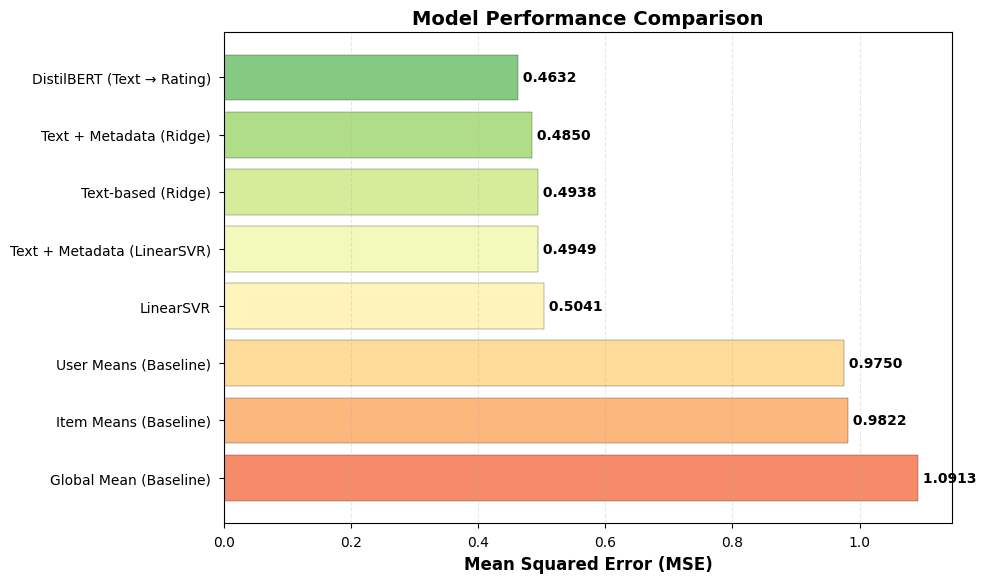

In [19]:
# ============================================================================
# Model Performance Visualization
# ============================================================================
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

# Sort by MSE (best to worst)
comparison_sorted = comparison_df.sort_values('MSE')

# Color gradient: green (best) to red (worst)
colors = plt.cm.RdYlGn_r(np.linspace(0.2, 0.8, len(comparison_sorted)))
bars = ax.barh(
    comparison_sorted['Model'],
    comparison_sorted['MSE'],
    color=colors,
    edgecolor='black',
    alpha=0.8
)

# Formatting
ax.set_xlabel('Mean Squared Error (MSE)', fontweight='bold', fontsize=12)
ax.set_title('Model Performance Comparison', fontweight='bold', fontsize=14)
ax.grid(axis='x', alpha=0.3, linestyle='--')
ax.invert_yaxis()  # Best model on top

# Add value labels on bars
for i, (idx, val) in enumerate(zip(comparison_sorted.index, comparison_sorted['MSE'])):
    ax.text(val, i, f' {val:.4f}', va='center', fontweight='bold', fontsize=10)

plt.tight_layout()
plt.savefig('model_performance_comparison.png', dpi=300, bbox_inches='tight')
plt.show()


### C. Performance Comparison 

In [20]:
# ============================================================================
# Performance Improvement Analysis
# ============================================================================

# Calculate improvement over baselines
baseline_mse = mse_global  # Global mean baseline
best_mse = comparison_df['MSE'].min()
best_model = comparison_df.loc[comparison_df['MSE'].idxmin(), 'Model']

print(f"\n{'='*80}")
print("PERFORMANCE IMPROVEMENT ANALYSIS")
print(f"{'='*80}")
print(f"\nBest Model: {best_model}")
print(f"Best MSE: {best_mse:.4f}")
print(f"\nImprovement over Global Mean Baseline:")
print(f"  Absolute reduction: {baseline_mse - best_mse:.4f}")
print(f"  Relative reduction: {(baseline_mse - best_mse) / baseline_mse * 100:.2f}%")

# Compare each model to global mean baseline
print(f"\n{'='*80}")
print("IMPROVEMENT OVER GLOBAL MEAN BASELINE")
print(f"{'='*80}")
comparison_df_sorted = comparison_df.sort_values('MSE')
for idx, row in comparison_df_sorted.iterrows():
    model_name = row['Model']
    mse = row['MSE']
    improvement = (baseline_mse - mse) / baseline_mse * 100
    print(f"{model_name:35s}: {improvement:6.2f}% improvement")

# Analyze feature contributions
print(f"\n{'='*80}")
print("FEATURE CONTRIBUTION ANALYSIS")
print(f"{'='*80}")

# Text-only models
ridge_text_only = comparison_df[comparison_df['Model'] == 'Text-based (Ridge)']['MSE'].values[0]
ridge_with_metadata = comparison_df[comparison_df['Model'] == 'Text + Metadata (Ridge)']['MSE'].values[0]
metadata_improvement_ridge = (ridge_text_only - ridge_with_metadata) / ridge_text_only * 100

svr_text_only = comparison_df[comparison_df['Model'] == 'LinearSVR']['MSE'].values[0]
svr_with_metadata = comparison_df[comparison_df['Model'] == 'Text + Metadata (LinearSVR)']['MSE'].values[0]
metadata_improvement_svr = (svr_text_only - svr_with_metadata) / svr_text_only * 100

print(f"\nMetadata Feature Contribution:")
print(f"  Ridge: {metadata_improvement_ridge:.2f}% improvement when adding metadata")
print(f"  LinearSVR: {metadata_improvement_svr:.2f}% improvement when adding metadata")

# Model architecture comparison
print(f"\nModel Architecture Comparison (Text + Metadata):")
print(f"  Ridge MSE: {ridge_with_metadata:.4f}")
print(f"  LinearSVR MSE: {svr_with_metadata:.4f}")
if ridge_with_metadata < svr_with_metadata:
    print(f"  → Ridge performs {(svr_with_metadata - ridge_with_metadata) / svr_with_metadata * 100:.2f}% better")
else:
    print(f"  → LinearSVR performs {(ridge_with_metadata - svr_with_metadata) / ridge_with_metadata * 100:.2f}% better")

print(f"{'='*80}")


PERFORMANCE IMPROVEMENT ANALYSIS

Best Model: DistilBERT (Text → Rating)
Best MSE: 0.4632

Improvement over Global Mean Baseline:
  Absolute reduction: 0.6281
  Relative reduction: 57.56%

IMPROVEMENT OVER GLOBAL MEAN BASELINE
DistilBERT (Text → Rating)         :  57.56% improvement
Text + Metadata (Ridge)            :  55.56% improvement
Text-based (Ridge)                 :  54.75% improvement
Text + Metadata (LinearSVR)        :  54.65% improvement
LinearSVR                          :  53.81% improvement
User Means (Baseline)              :  10.66% improvement
Item Means (Baseline)              :  10.00% improvement
Global Mean (Baseline)             :   0.00% improvement

FEATURE CONTRIBUTION ANALYSIS

Metadata Feature Contribution:
  Ridge: 1.77% improvement when adding metadata
  LinearSVR: 1.83% improvement when adding metadata

Model Architecture Comparison (Text + Metadata):
  Ridge MSE: 0.4850
  LinearSVR MSE: 0.4949
  → Ridge performs 1.99% better


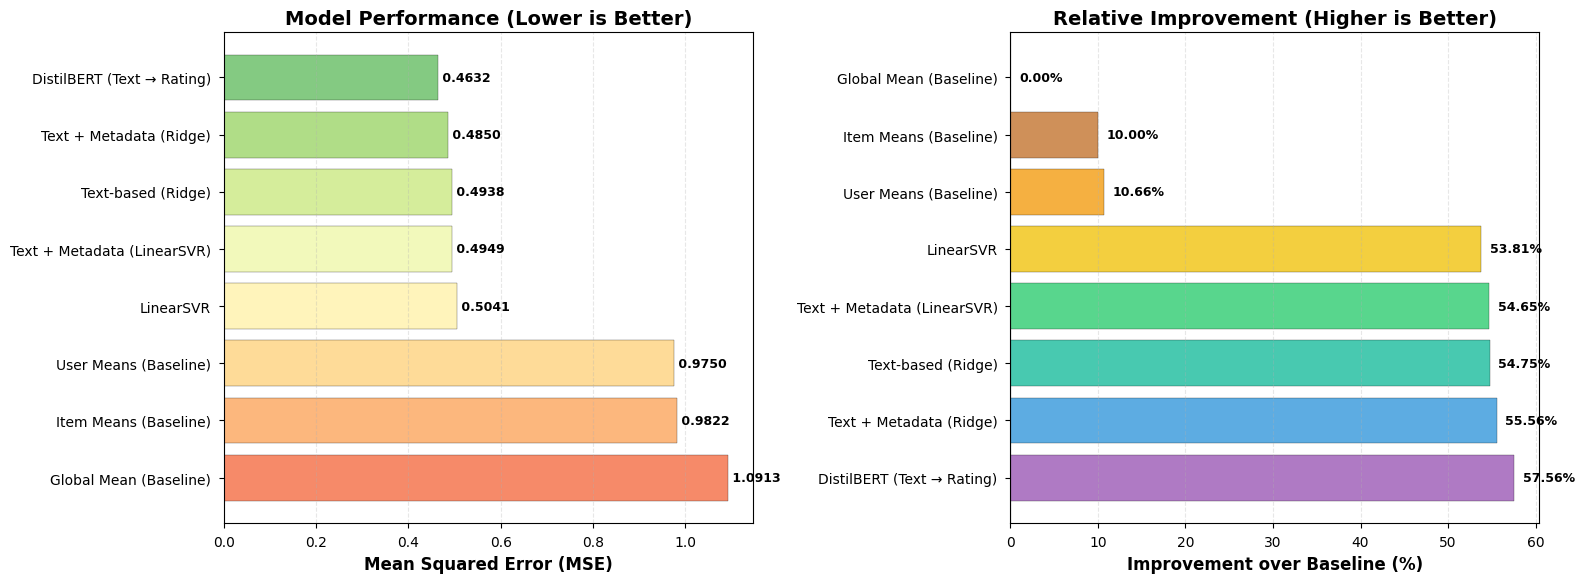

In [28]:
# ============================================================================
# Additional Visualization: Improvement Percentage Chart
# ============================================================================

# Calculate improvement percentages for all models
comparison_df_viz = comparison_df.copy()
comparison_df_viz['Improvement %'] = ((baseline_mse - comparison_df_viz['MSE']) / baseline_mse * 100)
comparison_df_viz = comparison_df_viz.sort_values('Improvement %', ascending=True)

# Create figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Chart 1: MSE Comparison (existing style but improved)
comparison_sorted = comparison_df.sort_values('MSE')
colors_mse = plt.cm.RdYlGn_r(np.linspace(0.2, 0.8, len(comparison_sorted)))
bars1 = axes[0].barh(
    comparison_sorted['Model'],
    comparison_sorted['MSE'],
    color=colors_mse,
    edgecolor='black',
    alpha=0.8
)

axes[0].set_xlabel('Mean Squared Error (MSE)', fontweight='bold', fontsize=12)
axes[0].set_title('Model Performance (Lower is Better)', fontweight='bold', fontsize=14)
axes[0].grid(axis='x', alpha=0.3, linestyle='--')
axes[0].invert_yaxis()

# Add value labels
for i, (idx, val) in enumerate(zip(comparison_sorted.index, comparison_sorted['MSE'])):
    axes[0].text(val, i, f' {val:.4f}', va='center', fontweight='bold', fontsize=9)

# Chart 2: Improvement Percentage
# Create distinct colors for each model
distinct_colors = ['#e74c3c', "#c4742f", '#f39c12', '#f1c40f', '#2ecc71', '#1abc9c', '#3498db', '#9b59b6']
# Assign colors based on sorted order (worst to best)
colors_imp = [distinct_colors[i] for i in range(len(comparison_df_viz))]
bars2 = axes[1].barh(
    comparison_df_viz['Model'],
    comparison_df_viz['Improvement %'],
    color=colors_imp,
    edgecolor='black',
    alpha=0.8
)

axes[1].axvline(x=0, color='black', linestyle='-', linewidth=1.5)
axes[1].set_xlabel('Improvement over Baseline (%)', fontweight='bold', fontsize=12)
axes[1].set_title('Relative Improvement (Higher is Better)', fontweight='bold', fontsize=14)
axes[1].grid(axis='x', alpha=0.3, linestyle='--')
axes[1].invert_yaxis()

# Add value labels
for i, (idx, val) in enumerate(zip(comparison_df_viz.index, comparison_df_viz['Improvement %'])):
    label_x = val + (1 if val >= 0 else -1)
    ha = 'left' if val >= 0 else 'right'
    axes[1].text(label_x, i, f'{val:.2f}%', va='center', ha=ha, fontweight='bold', fontsize=9)

plt.tight_layout()
plt.savefig('model_comparison_detailed.png', dpi=300, bbox_inches='tight')
plt.show()